<a href="https://colab.research.google.com/github/MRsources/MRzero-Core/blob/playground-dev/documentation/playground_mr0/mr0_FID_seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pypulseq &> /dev/null
!pip install MRzeroCore &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null

(FID_seq)=
# Free induction decay

In [ ]:
import numpy as np
import MRzeroCore as mr0
import pypulseq as pp
import matplotlib.pyplot as plt

Calculating repetition 1 / 1 - done


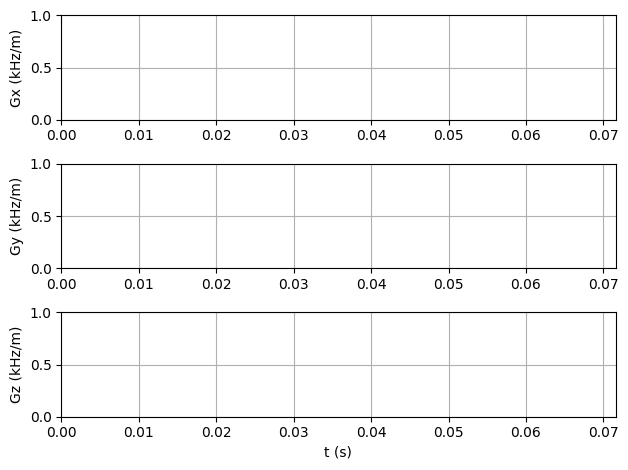

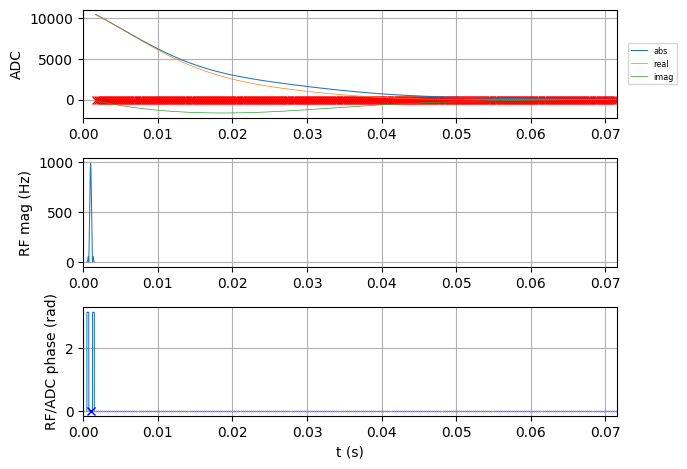

In [ ]:
#@title FID in a brain phantom - sequence
# %% S2. DEFINE the sequence, FOV and resolution
seq = pp.Sequence()
fov = 200e-3
Nread = 256
Nphase = 1
slice_thickness = 8e-3  # slice

experiment_id = 'FID'
# %% S1. SETUP sys
# choose the scanner limits
system = pp.Opts(
    max_grad=28, grad_unit='mT/m', max_slew=150, slew_unit='T/m/s',
    rf_ringdown_time=20e-6, rf_dead_time=100e-6,
    adc_dead_time=20e-6, grad_raster_time=10e-6
)


# Define rf events
rf1, _, _ = pp.make_sinc_pulse(
    flip_angle=90 * np.pi / 180, duration=1e-3,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    delay=0, system=system, return_gz=True
)
# rf1 = pp.make_block_pulse(flip_angle=90 * np.pi / 180, duration=1e-3, system=system)

# Define other gradients and ADC events
adc = pp.make_adc(num_samples=Nread, duration=70e-3, phase_offset=0 * np.pi / 180, delay=0, system=system)

# ======
# CONSTRUCT SEQUENCE
# ======
seq.add_block(rf1)
seq.add_block(adc)

#quick 2D brain phantom sim and plot
signal = mr0.util.simulate_2d(seq,)
seq.plot(plot_now=False)
mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
plt.show()


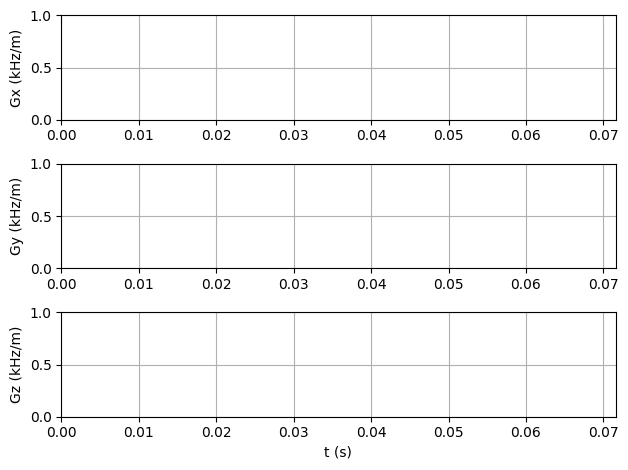

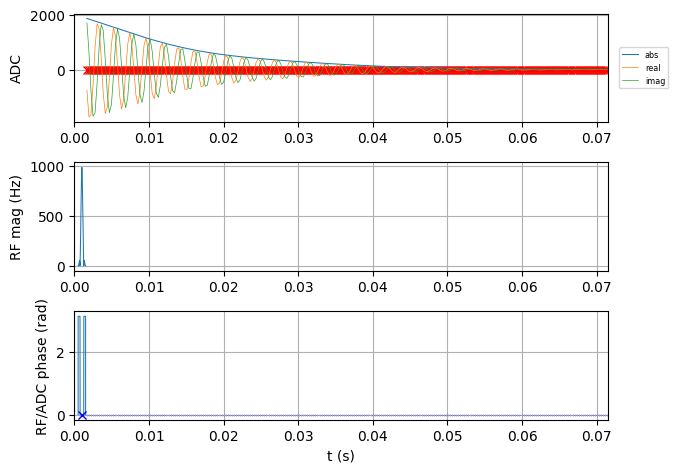

In [ ]:
#@title Detailed phantom definition and simulation ation


# Prepare the sequence output for the scanner
seq.set_definition('FOV', [fov, fov, slice_thickness])
seq.set_definition('Name', 'FID')
seq.write('FID.seq')
#@markdown  The B0 inhomogeneity brings you from the rotating frame FID at dB0=0, closer to the lab frame FID at dB0=B0.
#@markdown Try dB0=0 and dB0=500 for a test.
dB0 = 470 #@param {title:'dB0',type:"slider", min:0, max:500, step:10}
# %% S4: SETUP SPIN SYSTEM/object on which we can run the MR sequence external.seq from above
sz = [64, 64]
obj_p = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat')
obj_p = obj_p.interpolate(sz[0], sz[1], 1)
# Manipulate loaded data
obj_p.B0 += dB0
obj_p.D *= 0
#obj_p.plot()
# Convert Phantom into simulation data
obj_p = obj_p.build()

# %% S5:. SIMULATE  the external.seq file and add acquired signal to ADC plot
# Read in the sequence
seq0 = mr0.Sequence.import_file("FID.seq")
# seq0.plot_kspace_trajectory()
# Simulate the sequence
graph = mr0.compute_graph(seq0, obj_p, 200, 1e-3)
signal = mr0.execute_graph(graph, seq0, obj_p, print_progress=False)
# PLOT sequence with SIGNAL

seq.plot(plot_now=False)
mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
plt.show()

# plt.figure()
# plt.plot(signal.abs().numpy(),'.')
# plt.show()